In [1]:
import visualize_prediction as V
import eval_model as E
import pandas as pd
from torchvision import transforms, utils

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

In [38]:
PATH_TO_IMAGES = "../../dataset/"
PATH_TO_MODEL = "fine_tuning/checkpoint"

In [39]:
dataloader,model= V.load_rsna_data(PATH_TO_IMAGES,PATH_TO_MODEL,fold='val')
print(model)
print(len(dataloader))

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [40]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Scale(224),
            # because scale doesn't always give 224 x 224, this ensures 224 x
            # 224
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

model.cuda()

pred,auc = E.make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES)

0
160
320
480
640
800
960
1120
1280
1440
1600
1760
1920
2080
2240
2400
2560
2720
2880
3040
3200
3360
3520
3680
3840
4000
4160
4320
4480
4640
4800
4960
5120


In [41]:
#print(pred)
print(pred[dataloader.dataset.df['Target'].values == 1]['prob_Pneumonia'])
prob_pneumonia = pred[dataloader.dataset.df['Target'].values == 1]['prob_Pneumonia']
print('Minimum probability of pneumonia diagnosed patients is: '+str(prob_pneumonia.min()))

1       0.727270
3       0.743169
4       0.627418
6       0.669995
13      0.819762
16      0.628628
18      0.946795
23      0.846684
24      0.733540
25      0.625064
27      0.523582
32      0.987434
34      0.911765
35      0.569786
36      0.646933
37      0.657568
38      0.583683
41      0.779459
43      0.629950
47      0.962706
48      0.673607
49      0.705100
52      0.579128
53      0.772835
55      0.957607
59      0.921398
63      0.891752
65      0.781605
71      0.878574
72      0.834229
          ...   
5003    0.965018
5004    0.758032
5015    0.805241
5016    0.732948
5019    0.668388
5022    0.900255
5024    0.950014
5028    0.712632
5034    0.791818
5050    0.848135
5052    0.778778
5064    0.819802
5066    0.765123
5072    0.786824
5081    0.921105
5082    0.698312
5088    0.678772
5097    0.907882
5101    0.863095
5102    0.956519
5103    0.832492
5110    0.807452
5115    0.763894
5120    0.810108
5125    0.885691
5127    0.899590
5136    0.784584
5139    0.5705

In [42]:
# Taxa de aceitação de falso positivo

ths_prob = 0.55670476
prob_not_pneumonia = pred[dataloader.dataset.df['Target'].values == 0]['prob_Pneumonia']
total_pneumo = pred[dataloader.dataset.df['Target'].values == 1].values.shape[0]
total_not_pneumo = pred[dataloader.dataset.df['Target'].values == 0].values.shape[0]
n_not_pneumonia = prob_not_pneumonia[prob_not_pneumonia > ths_prob].count()
n_all = pred[pred['prob_Pneumonia'] > ths_prob]['prob_Pneumonia'].count()

print("Number of Postives In validation {} \n".format(total_pneumo))
print("Number of Negatives In validation {} \n".format(total_not_pneumo))

print("Number of patients",str(n_all))
print("Number of Postives",str(n_all-n_not_pneumonia))

print("Number of False Positives",str(n_not_pneumonia))

Number of Postives In validation 1184 

Number of Negatives In validation 3963 

Number of patients 2496
Number of Postives 1083
Number of False Positives 1413


In [43]:
df_positive = pred[pred['prob_Pneumonia'] > ths_prob]
df_to_predict = df_positive['patientId']
df_to_predict.to_csv('to_predict.csv')

In [44]:
pred.head()

,patientId,prob_Pneumonia,prob_not Pneumonia
0,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,0.522311,0.477689
1,00704310-78a8-4b38-8475-49f4573b2dbb.png,0.727270,0.272730
2,00a85be6-6eb0-421d-8acf-ff2dc0007e8a.png,0.521737,0.478263
3,00aecb01-a116-45a2-956c-08d2fa55433f.png,0.743169,0.256831
4,01a7353d-25bb-4ff8-916b-f50dd541dccf.png,0.627418,0.372582


In [45]:
from sklearn.metrics import roc_curve, auc

print(pred.shape)
fpr, tpr, ths = roc_curve(dataloader.dataset.df['Target'].values, pred.prob_Pneumonia.values)
roc_auc = auc(fpr, tpr)

(5147, 3)


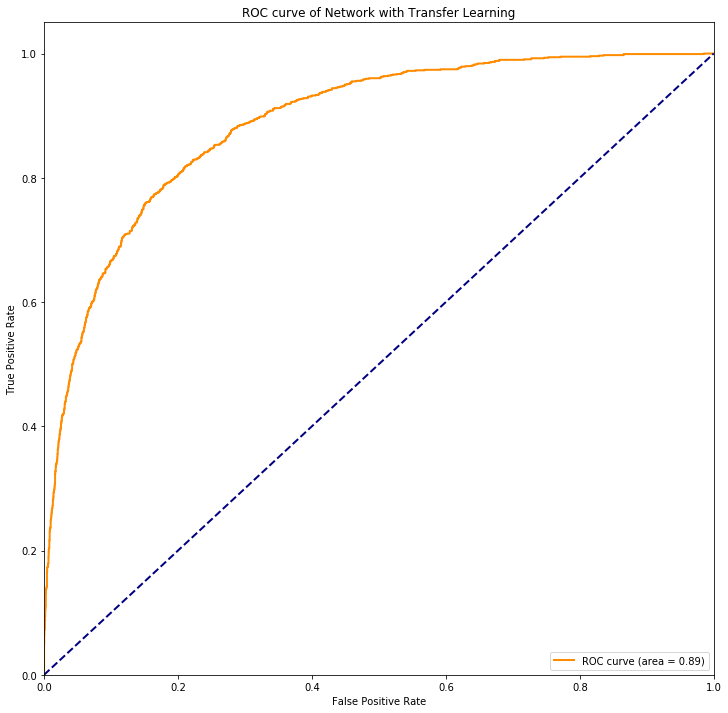

In [46]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,12))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Network with Transfer Learning')
plt.legend(loc="lower right")
plt.show()

In [47]:
target = -350
tpr[target:target+10],fpr[target:target+10],ths[target:target+10]

(array([0.83614865, 0.83614865, 0.83699324, 0.83699324, 0.83783784,
        0.83783784, 0.83868243, 0.83868243, 0.83952703, 0.83952703]),
 array([0.23441837, 0.2346707 , 0.2346707 , 0.23694171, 0.23694171,
        0.23744638, 0.23744638, 0.23870805, 0.23870805, 0.23896038]),
 array([0.59898525, 0.59886861, 0.59884864, 0.5980038 , 0.59791255,
        0.59765321, 0.59749353, 0.59680218, 0.5967316 , 0.59646147]))